# Analysis of STORM images

In [12]:
#Complete the dictionary with the values being the folders containing the datasets (each value is the path of the folder corresponding to one type of buffer and containing all the data associated to it). Note that the macro script should be run on the folder before using this code. The keys of the dictionary are the names you would like to give to the directories (label of the buffers).
paths = {'GLOX-MEA 100 mM': r'D:\everything\Polytechnique\S6\Bachelor Thesis\additional data article\GLOX MEA',
         'Optimized Buffer': r'D:\everything\Polytechnique\S6\Bachelor Thesis\additional data article\8D CF568 NO',
         
        }

# indicate the size of te pixels you want to compute the density (in nanometers)
length_nm = 30

#indicate the value of the first degree of freedom for each data
x_list = []
#indicate the value of the second degree of freedom for each data (in the same order)
y_list = []
# indicate the interval the order of magnitude of variation between the values in x_list (for examples 0.01 if values vary by at least 2 decimals, 1 if the vary by at least 1)
x_spacing = 0
# Do the same for y
y_spacing = 0
# Indicate the name of the degree of freedom x
x_label = ''
# Indicate the unit of the degree of freedom y
x_unit = ''
# Do the same for y
y_label = ''
y_unit = ''

Run next cell and then the cells you are interested in. Note that for cells with graphs outputs, you can save the plots by uncommenting the last line.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy.optimize
import math
import scipy.stats
import statistics
from scipy.interpolate import griddata
import os
import re
import cv2

number_paths = len(paths) # the number of paths


l, l2, l3 = [], [], [] 
for path in list(paths.values()): 
    lp1 = os.listdir(path) # list of the files in the path considered
    lp1 = list(filter(lambda x: x.endswith('avg.xls'), lp1)) # list of only the names of the files averaged
    l2p1 = [os.path.join(path, f) for f in lp1] # list of the directories of the files averaged
    l.append(lp1) # l is a list of sublists where each sublist is the lp1 of a path
    l3+=lp1 # list with all the averaged files in all the paths considered
    l2+= l2p1     # list of all the directories of the averaged files in the paths considered

d = dict(zip(l3, map(pd.read_table, l2))) # dictionary assigning to each averaged file the corresponding results table

## Density of molecules

### Density of molecules per micron squared

In [3]:
mean_mole= {} # dictionary assigning to each path a the mean density of molecules averaged between all the data taken in the path
density= {}
for i in range(number_paths):
    j,m= 0,[] 
    for file in l[i]: #looping over each averaged file in the path
        j+=1 # the number of the averaged file considered in the path 
        x_values = list(d[file]['X_(nm)']) # x_values extracted from the results table of the file
        y_values = list(d[file]['Y_(nm)']) #y_values
        bins_x = int(max([int(l) for l in x_values])/length_nm) #dividing the x_axis into intervals of 30nm
        bins_y = int(max([int(l) for l in y_values])/length_nm) #same for y_axis to get bins/pixels of 30nm by 30nm
        returns = plt.hist2d(x_values, y_values, bins = (bins_x, bins_y), cmap ="gray") 
        # returns plots a 2D histogram of the averaged image and extracts the number of molecules per pixel/bin as its 0th arg
        plt.title(list(paths.keys())[i]+": data "+str(j), fontweight ="bold") 
        #plots the 2D histogram.. remove the plt.close() at the end to get the histograms
        density[file] = [[int(bool(i)) for i in returns[0][j]] for j in range(bins_x)] 
        #density is a dictionary assigning to each averaged file in the path a list of sublists where the pixel (i,j) get a 0 value if it has no molcules and 1 otherwise 
        m.append(len(d[file])/(sum(sum(i) for i in density[file])*(max(x_values)*0.001*max(y_values)*0.001/(bins_y*bins_x))))
        # m is a list of in which the number of molecules/(surface of pixels containing at least 1 molecule (in microns))
    mean_mole[list(paths.keys())[i]] =np.mean(m) # the average of the densities of all the averaged files in the path is calculated
plt.close() 

print('Mean density of molecules per micron squared:', mean_mole);


Mean density of molecules per micron squared: {'GLOX': 3268.1536795394027, '8D': 6709.415307364593, 'Al647': 7133.928607602616, 'CF647': 5716.420583282097, 'Dy649': 5090.621801115993, 'CF750': 2109.2319090544697, 'Dy755': 2469.855636604391, 'CF770': 2618.404823172185}


### Evolution of the density

In [ ]:
# getIndexes is a function to get the index the number of the row (the number of the molecule) corresponding 
# to a certain value of Frame number. So it gives the number of the first molecule to appear in a given frame number.
def getIndexes(table, value): #dfObj is the table considered (an element of d)
    result = table.isin([value]) # isin() method will return a dataframe with boolean values, True at the positions where element exists
    return list(result['Frame Number'][result['Frame Number'] == True].index)

# idx is a dictionary whose keys are the filenames. Each file is assigned to a list in which the nth element is the
# is the closest frame number greater than or equal to 50+500*(n-1)
idx = {}
for name, df in d.items():
    idx[name] = [
    df[df['Frame Number'] >= fr]['Frame Number'].iloc[0]
    for fr in range(50,df['Frame Number'].max()+1, 500) ]
    
# idxcnt is also a dictionary where each name in names is assigned to a tuple. The tuple contains the list idx[name] 
# as the first arument. The second argument of the tuple is a list where the nth element is the number of the first 
# molecule to appear in the nth frame number in the list idx[name].
idxcnt = {}
for name, ids in idx.items():
    idxcnt[name] = (ids, [getIndexes(d[name], i)[0] for i in ids])

# For each path, we plot the mean of the curve idxcnt[name] of all filenames to get the average evolution of 
# the number of molecules.

for i in range(number_paths):
    plt.figure() 
    plt.plot(idxcnt[l[i][0]][0], [np.mean([idxcnt[name][1][j]/(sum(sum(i) for i in density[name])*(max(list(d[name]['X_(nm)']))*0.001*max(list(d[name]['Y_(nm)']))*0.001/bins_num**2)) for name in l[i]]) for j in range(len(idxcnt[l[i][0]][0]))], '--')
    plt.title(list(paths.keys())[i])
    plt.xlabel("Frame Number")
    plt.ylabel("Density (molecules/microns^2)")
    #uncomment next line to save the plot
    #plt.savefig(os.path.join(list(paths.values())[i], list(paths.keys())[i] +' Average Evolution of the density'+'.png'))



## SNR

### SNR distribution per dataset

In [ ]:
idxfreIt = {} 
for name, df in d.items(): # looping over each averaged file (name) and its result table (df)
    idxiter = [i for i in range(1,40)] # List of all the values of the SNR we are considering (from 1 to 40)
    idxfreIt[name] = (idxiter, [((df['SNR']> 0) &(df['SNR']>= idxiter[i]) &  (df['SNR'] < idxiter[i+1])).sum() for i in range(0, len(idxiter)-1) ])
    # For the ith value of SNR in idxiter, we count the number of molecules having an SNR greater or equal to it and strictly less than the value idxiter[i+1]
    # we assign to idxfreIt[name] a tuple with the first argument the list idxiter and the second argument the list of the values calculated
    
    
m=0 
for i in range(number_paths): # Looping over the paths
    j=0 
    f = plt.figure()
    for name in l[i]: # Looping over the averaged files in the path
        j+=1 # Number of the avergaed file considered in the path
        plt.bar(idxfreIt[name][0][:-1],np.array([idxfreIt[name][1][i]/len(d[list(d.keys())[m]]) for i in range(len(idxfreIt[name][1]))]), width = 0.6, label = "data "+ str(j))
        # We make a bar plot with the SNR values (idxiter) as the x-value and the corresponding number of molecules (calculated above), divided by the total number of molecules, as the y-value
        plt.title(list(paths.keys())[i]) 
        plt.xlabel("SNR")
        plt.ylabel("Fraction of Frames")
        plt.xlim([0,40])
        plt.legend()
        m+=1 # Number of the averaged file considered (-1)
    #uncomment next line to save the plot
    #plt.savefig(os.path.join(list(paths.values())[i], list(paths.keys())[i] + ' datum '+ str(j)+ ' Distribution of the SNR'+'.png'))

### Mean SNR distribution per dataset

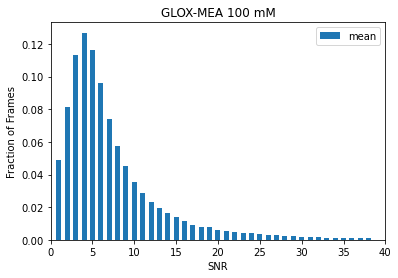

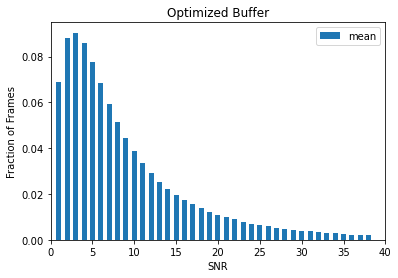

In [23]:
idxfreIt = {}
m=0
for i in range(number_paths): # Looping over the paths
    idxiter = [j for j in range(1,40)] # List of all the values of the SNR we are considering (from 1 to 40)
    elmt = [(d[l[i][j]]['SNR']> 0).sum() for j in range(len(l[i]))] 
    # creating a list of sublists. Each sublist contains the values of the SNR greater than 0 in one of the averaged files in the path.
    idxfreIt[list(paths.keys())[i]] = (idxiter, [np.mean([((d[l[i][j]]['SNR']> 0) & (d[l[i][j]]['SNR']>= idxiter[k]) & (d[l[i][j]]['SNR'] < idxiter[k+1])).sum()/elmt[j] for j in range(len(l[i]))]) for k in range(0, len(idxiter)-1)])
    # For the ith SNR value, for each averaged file, we calculate the number of molecules having an SNR between idxiter[i] and idxiter[i+1]
    # This value is normalized by the total number of molecules having a positive SNR in the averaged file.
    # The average is taken between all the average files
    m+=len(l[i]) # Number of the first file in a path
    
for i in range(number_paths):
    f = plt.figure()
    plt.bar(idxfreIt[list(paths.keys())[i]][0][:-1],height = np.array([idxfreIt[list(paths.keys())[i]][1][k] for k in range(len(idxfreIt[list(paths.keys())[i]][1]))]), width = 0.6, label = 'mean')
    # We make a bar plot with with the x-components the values of the SNR considered above (idxiter) and the y-components the corresponding averaged and normalized number of molecules calculated above
    plt.title(list(paths.keys())[i])
    plt.xlabel("SNR")
    plt.ylabel("Fraction of Frames")
    plt.xlim([0,40])
    plt.legend()
    #uncomment next line to save the plot
    #plt.savefig(os.path.join(list(paths.values())[i], list(paths.keys())[i] +' Average Distribution of the SNR'+'.png'))
    

### Mean SNR per dataset

In [4]:
SNR = {} 
for i in range(number_paths): # Looping over the paths
    li=[]
    for name in l[i]: # Looping over the averaged files in the path considered
        li.append(np.mean([d[name]['SNR'][s] for s in range(len(d[name])) if d[name]['SNR'][s]>0]))
        # li is a containing the average of the SNR values of all molecules for each average file
    SNR[list(paths.keys())[i]] = float("{:.2f}". format(np.mean(li)))
    # The SNR dictionary assigns to the path considered the mean of li, i.e. the mean of the averaged SNR between the data 

    
print('Mean SNR per dataset: ', SNR)


Mean SNR per dataset:  {'GLOX': 8.06, '8D': 10.02, 'Al647': 9.82, 'CF647': 18.9, 'Dy649': 13.91, 'CF750': 8.16, 'Dy755': 9.23, 'CF770': 7.32}


### Quantification of SNR decay per dataset

In [ ]:
idxfreIt = {}
m=0
for i in range(number_paths): # Looping over the paths
    idxiter = [j for j in range(20,41,20)] # Considering the SNR values between 20 and 41 and with an interval of 20, i.e. considering the interval [20,40]
    elmt = [(d[l[i][j]]['SNR']> 0).sum() for j in range(len(l[i]))] # same as in the "SNR distribution per dataset cell" but only for molecules in the interval of SNR considered
    idxfreIt[list(paths.keys())[i]] = (idxiter, [np.mean([((d[l[i][j]]['SNR']> 0) & (d[l[i][j]]['SNR']>= idxiter[k]) & (d[l[i][j]]['SNR'] < idxiter[k+1])).sum()/elmt[j] for j in range(len(l[i]))]) for k in range(0, len(idxiter)-1)])
    # same as in the "SNR distribution per dataset cell"
    m+=len(l[i]) # same as in the "SNR distribution per dataset cell"
    
print('Fraction of molecules with SNR between 20 and 40')
for i in range(number_paths): # Looping over the paths
    print(list(paths.keys())[i], np.array([idxfreIt[list(paths.keys())[i]][1][k] for k in range(len(idxfreIt[list(paths.keys())[i]][1]))])[idxfreIt[list(paths.keys())[i]][0][:-1].index(20)])
    # printing the average fraction of molecules with and SNR between 20 and 40 that was calculated above in the second argument of idxfreIt
print('')


### Density as a function of the SNR

In [ ]:
def getIndexes(table, value): # function that returns the index of the first molecule having a 
    result = table.isin([value])
    return list(result['SNR'][result['SNR'] == True].index)

idx = {}
for name, df in d.items():
    idx[name] = (range(0, 70,5), [(df['SNR']>= i).sum() for i in range(0, 70,5)])

idxcnt = {}
for name, ids in idx.items():
    idxcnt[name] = (ids, [len(getIndexes(d[name], i)) for i in ids])
    
plt.figure() 
for i in range(number_paths):
        plt.plot(idx[l[i][0]][0], [np.mean([idx[name][1][j]/(sum(sum(i) for i in density[name])*(max(list(d[name]['X_(nm)']))*0.001*max(list(d[name]['Y_(nm)']))*0.001/(bins_y*bins_x))) for name in l[i]]) for j in range(len(idx[l[i][0]][0]))], '--', label = list(paths.keys())[i])
plt.legend()
plt.xlabel("SNR")
plt.xlim([0,50])
plt.ylabel("Density (molecules/microns^2)")
#uncomment next line to save the plot
#plt.savefig('Density as a function of the SNR'+'.png')


## Photon Count

### Photon Count distribution per dataset

In [ ]:
# We do the exact same thing as previously done for the SNR with the variations indicated in comments
idxfreIt = {}
for name, df in d.items():
    idxiter = [i for i in range(1,6000,250)] # The values of photon count considered are between 1 and 6000 and with intervals of 500 
    idxfreIt[name] = (idxiter, [((df['IntegratedInt']>= 0) & (df['IntegratedInt']>= idxiter[i]) & (df['IntegratedInt'] < idxiter[i+1])).sum() for i in range(0, len(idxiter)-1)])    

m=0
for i in range(number_paths):
    j=0
    f = plt.figure()
    for name in l[i]:
        j+=1
        plt.bar(idxfreIt[name][0][:-1],height = np.array([idxfreIt[name][1][k]/len(d[list(d.keys())[m]]) for k in range(len(idxfreIt[name][1]))]), width = 400, label = "data "+ str(j))
        plt.title(list(paths.keys())[i])
        plt.xlabel("Photon Count")
        plt.ylabel("Fraction of Frames")
        plt.xlim([0,6000])
        plt.legend()
        m+=1
    #uncomment next line to save the plot
    #plt.savefig(os.path.join(list(paths.values())[i], list(paths.keys())[i] + ' datum '+ str(j)+ ' Distribution of the photon count'+'.png'))

### Mean Photon Count distribution per dataset

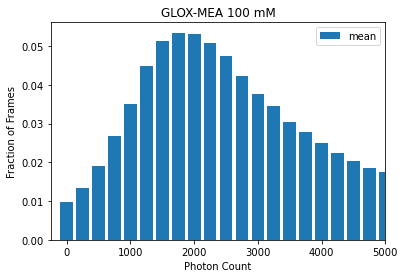

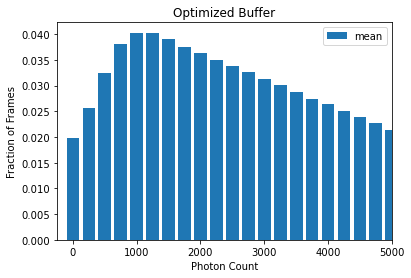

In [17]:
# We do the exact same thing as done previously with the SNR
idxfreIt = {}
m=0
for i in range(number_paths):
    idxiter = [j for j in range(1,6000,250)]
    elmt = [(d[l[i][j]]['IntegratedInt']> 0).sum() for j in range(len(l[i]))]
    idxfreIt[list(paths.keys())[i]] = (idxiter, [np.mean([((d[l[i][j]]['IntegratedInt']> 0) & (d[l[i][j]]['IntegratedInt']>= idxiter[k]) & (d[l[i][j]]['IntegratedInt'] < idxiter[k+1])).sum()/elmt[j] for j in range(len(l[i]))]) for k in range(0, len(idxiter)-1)])
    m+=len(l[i])

for i in range(number_paths):
    f = plt.figure()
    plt.bar(idxfreIt[list(paths.keys())[i]][0][:-1],height = np.array([idxfreIt[list(paths.keys())[i]][1][k] for k in range(len(idxfreIt[list(paths.keys())[i]][1]))]), width = 200, label = 'mean')
    plt.title(list(paths.keys())[i])
    plt.xlabel("Photon Count")
    plt.ylabel("Fraction of Frames")
    plt.xlim([-250,5000])
    plt.legend()  
    #uncomment next line to save the plot
    #plt.savefig(os.path.join(list(paths.values())[i], list(paths.keys())[i] +' Average Distribution of the photon count'+'.png'))
    

### Mean photon count per dataset

In [5]:
# We do the exact same thing as done previously with the SNR
Integrated_int = {}
for i in range(number_paths):
    li=[]
    for name in l[i]:
        li.append(np.mean([d[name]['IntegratedInt'][s] for s in range(len(d[name])) if d[name]['IntegratedInt'][s]>0]))
    Integrated_int[list(paths.keys())[i]] = float("{:.2f}". format(np.mean(li)))   

print('Integrated_int: ', Integrated_int)

Integrated_int:  {'GLOX': 5287.78, '8D': 4922.87, 'Al647': 9086.52, 'CF647': 5975.88, 'Dy649': 7639.86, 'CF750': 1726.4, 'Dy755': 2903.69, 'CF770': 2108.26}


### Quantification of the photon count decay per dataset

In [ ]:
# We do the exact same thing as done previously with the SNR. The variations are indicated in comments.
idxfreIt = {}
m=0
for i in range(number_paths):
    idxiter = [j for j in range(2000,6001,4000)] #This time we consider the molecules with a photon count between 2000 and 6000
    elmt = [(d[l[i][j]]['IntegratedInt']> 0).sum() for j in range(len(l[i]))]
    idxfreIt[list(paths.keys())[i]] = (idxiter, [np.mean([((d[l[i][j]]['IntegratedInt']> 0) & (d[l[i][j]]['IntegratedInt']>= idxiter[k]) & (d[l[i][j]]['IntegratedInt'] < idxiter[k+1])).sum()/elmt[j] for j in range(len(l[i]))]) for k in range(0, len(idxiter)-1)])
    m+=len(l[i])

print('probability for photon count between 2000 and 6000')
for i in range(number_paths):
    print(list(paths.keys())[i], np.array([idxfreIt[list(paths.keys())[i]][1][k] for k in range(len(idxfreIt[list(paths.keys())[i]][1]))])[idxfreIt[list(paths.keys())[i]][0][:-1].index(2000)])
print('')


## 2D histograms

Note that the cell calculating the mean of the parameter considered should be run first.

### 2D histogram of the SNR

In [ ]:
SNR_val = list(SNR.values()) # creating a list of all the SNR values in order
x_grid = np.arange(min(x_list)-5*x_spacing,max(x_list)+5*x_spacing,x_spacing)
#creating a grid going from the minimal value in the x degree of freedom -5*x_spacing to the maximal value+5*x_spacing and with intervals of x_spacing
y_grid = np.arange(min(y_list)-5*y_spacing,max(y_list)+5*y_spacing,y_spacing) # Same done with a y grid
[x_grid,y_grid] = np.meshgrid(x_grid,y_grid) # creation of a meshgrid between the 2 grids
z_grid = griddata((x_list,y_list), SNR_val, (x_grid, y_grid)) # the values (x,y) are assigned their SNR values
fig = plt.figure()
ax = fig.add_subplot(111) 
plt.contourf(x_grid,y_grid,z_grid)
plt.plot(x_list,y_list, 'k.') #plotting the 2D histogram
plt.xlabel(x_label + ' ('+x_unit+')')  
plt.ylabel(y_label + ' ('+y_unit+')') 
cbar = plt.colorbar()
cbar.ax.set_ylabel('SNR')
#uncomment next line to save the plot
#plt.savefig(list(paths.keys())[i] +'SNR histogram'+ '.png')

### 2D histogram of the density

In [ ]:
# We do with the density as previously done with the SNR
Dens = list(mean_mole.values())
x_grid = np.arange(min(x_list)-5*x_spacing,max(x_list)+5*x_spacing,x_spacing)
y_grid = np.arange(min(y_list)-5*y_spacing,max(y_list)+5*y_spacing,y_spacing)
[x_grid,y_grid] = np.meshgrid(x_grid,y_grid)
z_grid = griddata((x_list,y_list), Dens, (x_grid, y_grid))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(x_grid,y_grid,z_grid)
plt.plot(x_list,y_list, 'k.')
plt.xlabel(x_label + ' ('+x_unit+')')  
plt.ylabel(y_label + ' ('+y_unit+')') 
cbar = plt.colorbar()
cbar.ax.set_ylabel('Density (molecules/micron^2)')
#uncomment next line to save the plot
#plt.savefig(list(paths.keys())[i] +'Density 2D histogram DTT-Sodium Sulfite'+ '.png')

### 2D histogram of the photon count

In [ ]:
# We do the same with the integrated intensity as previously done with the SNR
Int_val = list(Integrated_int.values())
x_grid = np.arange(min(x_list)-5*x_spacing,max(x_list)+5*x_spacing,x_spacing)
y_grid = np.arange(min(y_list)-5*y_spacing,max(y_list)+5*y_spacing,y_spacing)
[x_grid,y_grid] = np.meshgrid(x_grid,y_grid)
z_grid = griddata((x_list,y_list), Int_val, (x_grid, y_grid))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(x_grid,y_grid,z_grid)
plt.plot(x_list,y_list, 'k.')
plt.xlabel(x_label + ' ('+x_unit+')')  
plt.ylabel(y_label + ' ('+y_unit+')') 
cbar = plt.colorbar()
cbar.ax.set_ylabel('Photon Count (photons)')
#uncomment next line to save the plot
#plt.savefig(list(paths.keys())[i] +'Photon Count 2D histogram'+ '.png')